## Performance Tuning Using Xgboost

Xgboost is a powerful and sophisticated Machine Learning algorithm which can deal with all sorts of irregularities of data.XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting algorithm.

Building a model using XGBoost is relativly straightfrward but, improving the model using XGBoost is a challenge. This algorithm uses multiple parameters. To improve the model, parameter tuning is must.

In this project we will try to implement and tune Xgboost on a dataset

### XGBoost Parameters

The overall parameters have been divided into 3 categories by XGBoost authors:

- General Parameters: Guide the overall functioning
- Booster Parameters: Guide the individual booster (tree/regression) at each step
- Learning Task Parameters: Guide the optimization performed

#### General Parameters

These define the overall functionality of XGBoost.

- booster [default=gbtree]
Select the type of model to run at each iteration. It has 2 options:
gbtree: tree-based models
gblinear: linear models

- silent [default=0]:
Silent mode is activated is set to 1, i.e. no running messages will be printed.It’s generally good to keep it 0 as the messages might help in understanding the model.

- nthread [default to maximum number of threads available if not set]
This is used for parallel processing and number of cores in the system should be entered.If you wish to run on all cores, value should not be entered and algorithm will detect automatically

#### Booster Parameters

Though there are 2 types of boosters, we’ll consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used.

- eta [default=0.3]
Analogous to learning rate in GBM.Makes the model more robust by shrinking the weights on each step.Typical final values to be used: 0.01-0.2

- min_child_weight [default=1]
Defines the minimum sum of weights of all observations required in a child.
This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
Too high values can lead to under-fitting hence, it should be tuned using CV.

- max_depth [default=6]
The maximum depth of a tree, same as GBM.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.
Typical values: 3-10

- max_leaf_nodes
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
If this is defined, GBM will ignore max_depth.

- gamma [default=0]
A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.

- max_delta_step [default=0]
In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.

- subsample [default=1]
Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
Typical values: 0.5-1

- colsample_bytree [default=1]
Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
Typical values: 0.5-1

- colsample_bylevel [default=1]
Denotes the subsample ratio of columns for each split, in each level.

- lambda [default=1]
L2 regularization term on weights (analogous to Ridge regression)
This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.

- alpha [default=0]
L1 regularization term on weight (analogous to Lasso regression)
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented

- scale_pos_weight [default=1]
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
 

#### Learning Task Parameters

These parameters are used to define the optimization objective the metric to be calculated at each step.

- objective [default=reg:linear]
This defines the loss function to be minimized. Mostly used values are:

    binary:logistic –logistic regression for binary classification, returns predicted probability (not class)

    multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
    you also need to set an additional num_class (number of classes) parameter defining the number of unique classes

    multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.


- eval_metric [ default according to objective ]
The metric to be used for validation data.
The default values are rmse for regression and error for classification.

    Typical values are:
    rmse – root mean square error
    
    mae – mean absolute error
    
    logloss – negative log-likelihood
    
    error – Binary classification error rate (0.5 threshold)
    
    merror – Multiclass classification error rate
    
    mlogloss – Multiclass logloss
    
    auc - Area under the curve
        
        

In [1]:
#Import libraries and reading the dataset
import pandas as pd
import numpy as np
import matplotlib
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

data = pd.read_csv("/Users/deedu/Documents/Study Material/Py Xgboost/Dataset/Train_nyc_copy.txt", encoding = "utf-8")

# Success - Display the first record
display(data.tail(n=100))

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
86920,ID124678I30,Female,Ankleshwar,55000,14-Oct-87,31-Jul-15,500000.0,5.0,10230.0,ONGC MANGALORE PETROCHEMICALS LTD,...,NaN,NaN,NaN,N,Web-browser,G,S122,3,0,0
86921,ID124680K00,Male,Delhi,30445,15-Mar-66,31-Jul-15,0.0,0.0,0.0,BSF,...,NaN,NaN,NaN,N,Mobile,G,S122,3,0,0
86922,ID124681L10,Male,Bengaluru,20140,05-Jun-92,31-Jul-15,500000.0,4.0,0.0,ALLEGIS SERVICE INDIA PVT LTD,...,18.15,4100.0,12075.91,Y,Web-browser,G,S122,5,0,0
86923,ID124683N30,Female,Jaipur,91000,23-Jul-82,31-Jul-15,0.0,0.0,0.0,MOET HENNESSY INDIA PVT LTD,...,NaN,NaN,NaN,N,Mobile,G,S122,3,0,0
86924,ID124684O40,Female,Raipur,56000,01-Dec-60,31-Jul-15,200000.0,4.0,35000.0,ACCOUNTANT GENERAL OFFICE,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
86925,ID124685P00,Male,Delhi,57000,10-Jan-86,31-Jul-15,1000000.0,5.0,0.0,ETECHACES MARKETING AND CONSULTING PVT LTD,...,NaN,NaN,NaN,N,Web-browser,G,S122,3,1,0
86926,ID124686Q10,Female,Delhi,15000,30-Sep-90,31-Jul-15,500000.0,5.0,6000.0,VIJENDER,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
86927,ID124689T40,Female,Bengaluru,10000,27-Mar-92,31-Jul-15,0.0,0.0,0.0,ACS XEROX,...,NaN,NaN,NaN,N,Mobile,G,S122,1,0,0
86928,ID124690U00,Male,Delhi,40000,18-May-78,31-Jul-15,1000000.0,0.0,0.0,GETARTY COMMUNICATION,...,15.25,17000.0,23763.99,Y,Web-browser,G,S122,5,0,0
86929,ID124692W20,Female,Bengaluru,14800,06-May-90,31-Jul-15,0.0,0.0,0.0,DENAVE INDIA PVT LTD,...,NaN,NaN,NaN,N,Mobile,G,S122,3,0,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 26 columns):
ID                       87020 non-null object
Gender                   87020 non-null object
City                     86017 non-null object
Monthly_Income           87020 non-null int64
DOB                      87020 non-null object
Lead_Creation_Date       87020 non-null object
Loan_Amount_Applied      86949 non-null float64
Loan_Tenure_Applied      86949 non-null float64
Existing_EMI             86949 non-null float64
Employer_Name            86949 non-null object
Salary_Account           75256 non-null object
Mobile_Verified          87020 non-null object
Var5                     87020 non-null int64
Var1                     87020 non-null object
Loan_Amount_Submitted    52407 non-null float64
Loan_Tenure_Submitted    52407 non-null float64
Interest_Rate            27726 non-null float64
Processing_Fee           27420 non-null float64
EMI_Loan_Submitted       27726 non-null 

### Data Exploration and Preperation

In [3]:


# TODO: Total number of records
n_records = len(data.index)

# TODO: Number of records where individual's income is more than $50,000
n_disbursed_0 = len(data[data['Disbursed'] == 0])

# TODO: Number of records where individual's income is at most $50,000
n_disbursed_1 = len(data[data['Disbursed'] == 1])

# TODO: Percentage of individuals whose income is more than $50,000
disb_percent = round(n_disbursed_1/n_records*100,2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Total Loan disbursed: {}".format(n_disbursed_0))
print("Total loan  not disbursed: {}".format(n_disbursed_1))
print("Percentage of loan disbursement: {}%".format(disb_percent))

Total number of records: 87020
Total Loan disbursed: 85747
Total loan  not disbursed: 1273
Percentage of loan disbursement: 1.46%


### Prepairing the data

In [4]:
drop_list = ['Disbursed','City','Lead_Creation_date','ID','DOB','EMI_Loan_Submitted','Employer_Name','LoggedIn','Salary_Account','Interest_Rate','Loan_Tenure_Submitted','Loan_Tenure_Submitted','Processing_Fee']
disb = data['Disbursed']
features_raw = data
#features_raw = data.drop('Disbursed', axis = 1)


In [5]:
import datetime as dt
features_raw['age'] = pd.to_datetime(data['DOB'])
features_raw['age'] = dt.datetime.today().year-features_raw['age'].dt.year

In [6]:
features_raw

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed,age
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,N,Web-browser,G,S122,1,0,0,41
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,NaN,6762.90,N,Web-browser,G,S122,3,0,0,34
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,N,Web-browser,B,S143,1,0,0,38
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,N,Web-browser,B,S143,3,0,0,32
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,N,Web-browser,B,S134,3,1,0,35
5,ID000010K00,Male,Bengaluru,45000,21-Apr-82,20-May-15,300000.0,5.0,15000.0,COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD,...,1500.0,6978.92,N,Web-browser,B,S143,3,1,0,37
6,ID000011L10,Female,Sindhudurg,70000,23-Oct-87,01-May-15,6.0,5.0,0.0,CARNIVAL CRUISE LINE,...,NaN,NaN,N,Web-browser,B,S133,1,0,0,32
7,ID000012M20,Male,Bengaluru,20000,25-Jul-75,20-May-15,200000.0,5.0,2597.0,GOLDEN TULIP FLORITECH PVT. LTD,...,NaN,NaN,N,Web-browser,B,S159,3,0,0,44
8,ID000013N30,Male,Kochi,75000,26-Jan-72,02-May-15,0.0,0.0,0.0,SIIS PVT LTD,...,26000.0,30824.65,Y,Mobile,C,S122,5,0,0,47
9,ID000014O40,Female,Mumbai,30000,12-Sep-89,03-May-15,300000.0,3.0,0.0,SOUNDCLOUD.COM,...,1500.0,10883.38,N,Web-browser,B,S133,1,0,0,30


In [7]:
features_raw['emi_loan_missing'] = data['EMI_Loan_Submitted'].apply(lambda x:0 if x>0 else 1)

In [8]:
features_raw

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed,age,emi_loan_missing
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,N,Web-browser,G,S122,1,0,0,41,1
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,6762.90,N,Web-browser,G,S122,3,0,0,34,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,N,Web-browser,B,S143,1,0,0,38,1
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,N,Web-browser,B,S143,3,0,0,32,1
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,N,Web-browser,B,S134,3,1,0,35,1
5,ID000010K00,Male,Bengaluru,45000,21-Apr-82,20-May-15,300000.0,5.0,15000.0,COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD,...,6978.92,N,Web-browser,B,S143,3,1,0,37,0
6,ID000011L10,Female,Sindhudurg,70000,23-Oct-87,01-May-15,6.0,5.0,0.0,CARNIVAL CRUISE LINE,...,NaN,N,Web-browser,B,S133,1,0,0,32,1
7,ID000012M20,Male,Bengaluru,20000,25-Jul-75,20-May-15,200000.0,5.0,2597.0,GOLDEN TULIP FLORITECH PVT. LTD,...,NaN,N,Web-browser,B,S159,3,0,0,44,1
8,ID000013N30,Male,Kochi,75000,26-Jan-72,02-May-15,0.0,0.0,0.0,SIIS PVT LTD,...,30824.65,Y,Mobile,C,S122,5,0,0,47,0
9,ID000014O40,Female,Mumbai,30000,12-Sep-89,03-May-15,300000.0,3.0,0.0,SOUNDCLOUD.COM,...,10883.38,N,Web-browser,B,S133,1,0,0,30,0


In [9]:
features_raw['emi_loan_missing'] = data['EMI_Loan_Submitted'].apply(lambda x:0 if x>0 else 1)

In [10]:
features_raw['Interest_Rate_missing'] = data['Interest_Rate'].apply(lambda x:0 if x>0 else 1)

In [11]:
display(features_raw[['Interest_Rate','Interest_Rate_missing']].head(10))

,Interest_Rate,Interest_Rate_missing
0,NaN,1
1,13.25,0
2,NaN,1
3,NaN,1
4,NaN,1
5,13.99,0
6,NaN,1
7,NaN,1
8,14.85,0
9,18.25,0


In [12]:
features_raw['Loan_Amount_Submitted_missing'] = data['Loan_Amount_Submitted'].apply(lambda x:0 if x>0 else 1)

In [13]:
features_raw['Loan_Tenure_Submitted_missing'] = data['Loan_Tenure_Submitted'].apply(lambda x:0 if x>0 else 1)

In [14]:
display(features_raw[['Loan_Amount_Submitted','Loan_Amount_Submitted_missing','Loan_Tenure_Submitted','Loan_Tenure_Submitted_missing']].head(10))

,Loan_Amount_Submitted,Loan_Amount_Submitted_missing,Loan_Tenure_Submitted,Loan_Tenure_Submitted_missing
0,NaN,1,NaN,1
1,200000.0,0,2.0,0
2,450000.0,0,4.0,0
3,920000.0,0,5.0,0
4,500000.0,0,2.0,0
5,300000.0,0,5.0,0
6,NaN,1,NaN,1
7,200000.0,0,5.0,0
8,1300000.0,0,5.0,0
9,300000.0,0,3.0,0


In [15]:
features_raw['Processing_Fee_missing'] = data['Processing_Fee'].apply(lambda x:0 if x>0 else 1)

In [16]:
display(features_raw[['Loan_Amount_Submitted','Loan_Amount_Submitted_missing','Loan_Tenure_Submitted','Loan_Tenure_Submitted_missing','Processing_Fee','Processing_Fee_missing']].head(10))

,Loan_Amount_Submitted,Loan_Amount_Submitted_missing,Loan_Tenure_Submitted,Loan_Tenure_Submitted_missing,Processing_Fee,Processing_Fee_missing
0,NaN,1,NaN,1,NaN,1
1,200000.0,0,2.0,0,NaN,1
2,450000.0,0,4.0,0,NaN,1
3,920000.0,0,5.0,0,NaN,1
4,500000.0,0,2.0,0,NaN,1
5,300000.0,0,5.0,0,1500.0,0
6,NaN,1,NaN,1,NaN,1
7,200000.0,0,5.0,0,NaN,1
8,1300000.0,0,5.0,0,26000.0,0
9,300000.0,0,3.0,0,1500.0,0


In [17]:
features_raw['Source'].value_counts()

S122    38567
S133    29885
S159     5599
S143     4332
S127     1931
S137     1724
S134     1301
S161      769
S151      720
S157      650
S153      494
S156      308
S144      299
S158      208
S123       73
S141       57
S162       36
S124       24
S160       11
S150       10
S155        4
S136        3
S138        3
S139        3
S129        3
S135        2
S130        1
S140        1
S154        1
S125        1
Name: Source, dtype: int64

In [18]:
features_raw['Source'] = data['Source'].apply(lambda x:x if (x=='S122' or x=='S133') else 'other')

In [19]:
display(features_raw[['Loan_Amount_Submitted','Loan_Amount_Submitted_missing','Loan_Tenure_Submitted','Loan_Tenure_Submitted_missing','Processing_Fee','Processing_Fee_missing','Source']].head(10))

,Loan_Amount_Submitted,Loan_Amount_Submitted_missing,Loan_Tenure_Submitted,Loan_Tenure_Submitted_missing,Processing_Fee,Processing_Fee_missing,Source
0,NaN,1,NaN,1,NaN,1,S122
1,200000.0,0,2.0,0,NaN,1,S122
2,450000.0,0,4.0,0,NaN,1,other
3,920000.0,0,5.0,0,NaN,1,other
4,500000.0,0,2.0,0,NaN,1,other
5,300000.0,0,5.0,0,1500.0,0,other
6,NaN,1,NaN,1,NaN,1,S133
7,200000.0,0,5.0,0,NaN,1,other
8,1300000.0,0,5.0,0,26000.0,0,S122
9,300000.0,0,3.0,0,1500.0,0,S133


In [20]:

display(features_raw[['Loan_Amount_Applied','Loan_Tenure_Applied']].head(10))

,Loan_Amount_Applied,Loan_Tenure_Applied
0,300000.0,5.0
1,200000.0,2.0
2,600000.0,4.0
3,1000000.0,5.0
4,500000.0,2.0
5,300000.0,5.0
6,6.0,5.0
7,200000.0,5.0
8,0.0,0.0
9,300000.0,3.0


In [21]:
features_raw['Loan_Amount_Applied'] = data['Loan_Amount_Applied'].apply(lambda x:x if (x>=0.0) else data['Loan_Amount_Applied'].mean())
features_raw['Loan_Tenure_Applied'] = data['Loan_Tenure_Applied'].apply(lambda x:x if (x>=0.0) else data['Loan_Tenure_Applied'].mean())

In [22]:
display(features_raw[['Loan_Amount_Applied','Loan_Tenure_Applied']].head(10))

,Loan_Amount_Applied,Loan_Tenure_Applied
0,300000.0,5.0
1,200000.0,2.0
2,600000.0,4.0
3,1000000.0,5.0
4,500000.0,2.0
5,300000.0,5.0
6,6.0,5.0
7,200000.0,5.0
8,0.0,0.0
9,300000.0,3.0


In [23]:
drop_list = ['Disbursed','City','ID','EMI_Loan_Submitted','LoggedIn','Salary_Account','Interest_Rate','Loan_Tenure_Submitted','Loan_Tenure_Submitted','Processing_Fee']
disb = data['Disbursed']
features_raw = features_raw.drop(drop_list, axis = 1)



In [28]:
features_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 19 columns):
Gender                           87020 non-null object
Monthly_Income                   87020 non-null int64
Loan_Amount_Applied              87020 non-null float64
Loan_Tenure_Applied              87020 non-null float64
Existing_EMI                     86949 non-null float64
Mobile_Verified                  87020 non-null object
Var5                             87020 non-null int64
Var1                             87020 non-null object
Filled_Form                      87020 non-null object
Device_Type                      87020 non-null object
Var2                             87020 non-null object
Source                           87020 non-null object
Var4                             87020 non-null int64
age                              87020 non-null int64
emi_loan_missing                 87020 non-null int64
Interest_Rate_missing            87020 non-null int64
Loan_Amount_Su

In [25]:
display(features_raw.head(10))

,Gender,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Mobile_Verified,Var5,...,Device_Type,Var2,Source,Var4,age,emi_loan_missing,Interest_Rate_missing,Loan_Amount_Submitted_missing,Loan_Tenure_Submitted_missing,Processing_Fee_missing
0,Female,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,N,0,...,Web-browser,G,S122,1,41,1,1,1,1,1
1,Male,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),Y,13,...,Web-browser,G,S122,3,34,0,0,0,0,1
2,Male,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,Y,0,...,Web-browser,B,other,1,38,1,1,0,0,1
3,Male,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,Y,10,...,Web-browser,B,other,3,32,1,1,0,0,1
4,Male,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,Y,17,...,Web-browser,B,other,3,35,1,1,0,0,1
5,Male,45000,21-Apr-82,20-May-15,300000.0,5.0,15000.0,COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD,Y,17,...,Web-browser,B,other,3,37,0,0,0,0,0
6,Female,70000,23-Oct-87,01-May-15,6.0,5.0,0.0,CARNIVAL CRUISE LINE,N,0,...,Web-browser,B,S133,1,32,1,1,1,1,1
7,Male,20000,25-Jul-75,20-May-15,200000.0,5.0,2597.0,GOLDEN TULIP FLORITECH PVT. LTD,Y,3,...,Web-browser,B,other,3,44,1,1,0,0,1
8,Male,75000,26-Jan-72,02-May-15,0.0,0.0,0.0,SIIS PVT LTD,Y,13,...,Mobile,C,S122,5,47,0,0,0,0,0
9,Female,30000,12-Sep-89,03-May-15,300000.0,3.0,0.0,SOUNDCLOUD.COM,Y,0,...,Web-browser,B,S133,1,30,0,0,0,0,0


In [26]:
features_raw = features_raw.drop(['Loan_Amount_Submitted','Lead_Creation_Date','DOB'], axis = 1)


In [27]:
features_raw = features_raw.drop(['Employer_Name'], axis = 1)

### Normalizing Numerical features

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['Monthly_Income','Loan_Amount_Applied','Loan_Tenure_Applied','Existing_EMI','Var5','Var4','age']

features_minmax_transform = pd.DataFrame(data = features_raw)
features_minmax_transform[numerical] = scaler.fit_transform(features_minmax_transform[numerical])

display(features_minmax_transform.head(10))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Gender,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Mobile_Verified,Var5,Var1,Filled_Form,Device_Type,Var2,Source,Var4,age,emi_loan_missing,Interest_Rate_missing,Loan_Amount_Submitted_missing,Loan_Tenure_Submitted_missing,Processing_Fee_missing
0,Female,0.000045,3.000000e-02,0.5,0.00000,N,0.000000,HBXX,N,Web-browser,G,S122,0.142857,0.909091,1,1,1,1,1
1,Male,0.000079,2.000000e-02,0.2,0.00000,Y,0.722222,HBXA,N,Web-browser,G,S122,0.428571,0.838384,0,0,0,0,1
2,Male,0.000051,6.000000e-02,0.4,0.00000,Y,0.000000,HBXX,N,Web-browser,B,other,0.142857,0.878788,1,1,0,0,1
3,Male,0.000079,1.000000e-01,0.5,0.00000,Y,0.555556,HBXX,N,Web-browser,B,other,0.428571,0.818182,1,1,0,0,1
4,Male,0.000225,5.000000e-02,0.2,0.00250,Y,0.944444,HBXX,N,Web-browser,B,other,0.428571,0.848485,1,1,0,0,1
5,Male,0.000101,3.000000e-02,0.5,0.00150,Y,0.944444,HAXM,N,Web-browser,B,other,0.428571,0.868687,0,0,0,0,0
6,Female,0.000157,6.000000e-07,0.5,0.00000,N,0.000000,HBXX,N,Web-browser,B,S133,0.142857,0.818182,1,1,1,1,1
7,Male,0.000045,2.000000e-02,0.5,0.00026,Y,0.166667,HBXX,N,Web-browser,B,other,0.428571,0.939394,1,1,0,0,1
8,Male,0.000169,0.000000e+00,0.0,0.00000,Y,0.722222,HAXB,Y,Mobile,C,S122,0.714286,0.969697,0,0,0,0,0
9,Female,0.000067,3.000000e-02,0.3,0.00000,Y,0.000000,HBXC,N,Web-browser,B,S133,0.142857,0.797980,0,0,0,0,0


In [30]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
outcome = disb

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

49 total features after one-hot encoding.


In [31]:
## To-do : Implement Xgboost trinng function
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

# Make xgb matrix
xgbtrain = xgb.DMatrix(features_final,label=outcome)


In [32]:
data_test = pd.read_csv("/Users/deedu/Documents/Study Material/Py Xgboost/Dataset/Test_bCtAN1w.csv", encoding = "utf-8")

# Success - Display the first record
display(data.tail(n=100))

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Source,Var4,LoggedIn,Disbursed,age,emi_loan_missing,Interest_Rate_missing,Loan_Amount_Submitted_missing,Loan_Tenure_Submitted_missing,Processing_Fee_missing
86920,ID124678I30,Female,Ankleshwar,55000,14-Oct-87,31-Jul-15,500000.000000,5.000000,10230.0,ONGC MANGALORE PETROCHEMICALS LTD,...,S122,3,0,0,32,1,1,1,1,1
86921,ID124680K00,Male,Delhi,30445,15-Mar-66,31-Jul-15,0.000000,0.000000,0.0,BSF,...,S122,3,0,0,-47,1,1,0,0,1
86922,ID124681L10,Male,Bengaluru,20140,05-Jun-92,31-Jul-15,500000.000000,4.000000,0.0,ALLEGIS SERVICE INDIA PVT LTD,...,S122,5,0,0,27,0,0,0,0,0
86923,ID124683N30,Female,Jaipur,91000,23-Jul-82,31-Jul-15,0.000000,0.000000,0.0,MOET HENNESSY INDIA PVT LTD,...,S122,3,0,0,37,1,1,0,0,1
86924,ID124684O40,Female,Raipur,56000,01-Dec-60,31-Jul-15,200000.000000,4.000000,35000.0,ACCOUNTANT GENERAL OFFICE,...,S122,1,0,0,-41,1,1,1,1,1
86925,ID124685P00,Male,Delhi,57000,10-Jan-86,31-Jul-15,1000000.000000,5.000000,0.0,ETECHACES MARKETING AND CONSULTING PVT LTD,...,S122,3,1,0,33,1,1,0,0,1
86926,ID124686Q10,Female,Delhi,15000,30-Sep-90,31-Jul-15,500000.000000,5.000000,6000.0,VIJENDER,...,S122,1,0,0,29,1,1,1,1,1
86927,ID124689T40,Female,Bengaluru,10000,27-Mar-92,31-Jul-15,0.000000,0.000000,0.0,ACS XEROX,...,S122,1,0,0,27,1,1,1,1,1
86928,ID124690U00,Male,Delhi,40000,18-May-78,31-Jul-15,1000000.000000,0.000000,0.0,GETARTY COMMUNICATION,...,S122,5,0,0,41,0,0,0,0,0
86929,ID124692W20,Female,Bengaluru,14800,06-May-90,31-Jul-15,0.000000,0.000000,0.0,DENAVE INDIA PVT LTD,...,S122,3,0,0,29,1,1,0,0,1


In [33]:
####
##param={'max_depth':5,
#       'eta':0.1,
#       'objective':'binary:logistic',
#       'nthread':4,
#       'scale_pos_weight':1,
#       'n_estimators':1000,
#       'min_child_weight':1,
#       'gamma':0,
#       'subsample':0.8,
#       'colsample_bytree':0.8,
#       'silent':1
#      }

xgb1 = XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     scale_pos_weight=1,
     seed=27
)

In [34]:
res=xgb.cv(xgb1.get_xgb_params(),
           xgbtrain,
           num_boost_round=xgb1.get_params()['n_estimators'],
           nfold=5,
           early_stopping_rounds=50,
           metrics='auc'
          )

print(res)

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.770105       0.012648       0.765980      0.013074
1          0.797309       0.005515       0.792542      0.022099
2          0.810196       0.003894       0.804257      0.021830
3          0.814730       0.003429       0.807366      0.018454
4          0.820649       0.005044       0.811723      0.017285
5          0.825492       0.004933       0.815440      0.016347
6          0.828813       0.003887       0.818157      0.016015
7          0.831930       0.003780       0.818527      0.016338
8          0.833889       0.004266       0.818654      0.016093
9          0.836544       0.004058       0.819617      0.016810
10         0.838575       0.004101       0.820382      0.016101
11         0.839786       0.004341       0.820509      0.015978
12         0.842081       0.005167       0.821897      0.013978
13         0.842736       0.005108       0.821963      0.013495
14         0.843740       0.005230      

In [35]:
## Predict training set
xgb1.set_params(n_estimators=res.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=155,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [36]:
xgb1.fit(features_final,outcome,eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=155,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [37]:
xgb1_pred = xgb1.predict(features_final)
xgb1_pred_prob = xgb1.predict_proba(features_final)[:,1]

In [38]:
print ("\nModel Report")
print ("Accuracy : {:.4g}".format(metrics.accuracy_score(outcome, xgb1_pred)))
print ("AUC Score (Train): {:.4f}".format(metrics.roc_auc_score(outcome, xgb1_pred_prob)))


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.9053


In [39]:
xgb1.get_booster().get_fscore()


{'Monthly_Income': 683,
 'Var5': 246,
 'Existing_EMI': 360,
 'Device_Type_Web-browser': 9,
 'Filled_Form_N': 54,
 'age': 428,
 'Var1_HAXB': 36,
 'Var1_HAXC': 32,
 'Loan_Amount_Applied': 276,
 'Loan_Amount_Submitted_missing': 23,
 'Var1_HBXA': 35,
 'Var2_C': 25,
 'Source_S133': 45,
 'Var4': 155,
 'Source_other': 40,
 'Var2_B': 34,
 'Loan_Tenure_Applied': 136,
 'Var1_HBXC': 22,
 'Device_Type_Mobile': 30,
 'Filled_Form_Y': 12,
 'Var1_HCXD': 5,
 'Gender_Female': 31,
 'Source_S122': 45,
 'Gender_Male': 6,
 'Var1_HBXB': 29,
 'Var1_HAXA': 25,
 'Var1_HAXM': 11,
 'Var1_HBXD': 20,
 'emi_loan_missing': 22,
 'Processing_Fee_missing': 13,
 'Loan_Tenure_Submitted_missing': 4,
 'Var2_G': 28,
 'Var1_HAYT': 5,
 'Var1_HCXF': 10,
 'Interest_Rate_missing': 2,
 'Mobile_Verified_N': 7,
 'Var1_HBXH': 6,
 'Var2_E': 8,
 'Mobile_Verified_Y': 6,
 'Var2_D': 7,
 'Var1_HVYS': 9,
 'Var1_HAVC': 7,
 'Var1_HCYS': 2,
 'Var2_F': 3}

In [40]:
feat_imp = pd.DataFrame.from_dict(xgb1.get_booster().get_fscore(), orient='index')

In [41]:
feat_imp=feat_imp.sort_values(by = 0, ascending = False)

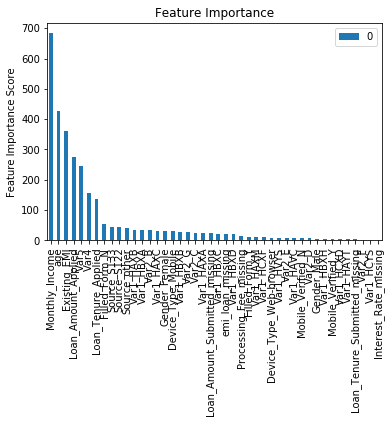

In [42]:
plt=feat_imp.plot(kind = 'bar', title='Feature Importance')
plt.set_ylabel('Feature Importance Score')
matplotlib.rcParams['figure.figsize'] = [18, 10]


In [54]:
## Tune Max_depth and min_child_weight
from sklearn.metrics import make_scorer

param={'max_depth':range(3,10,2),
       'min_child_weight':range(1,6,2)
      }

scoring = 'roc_auc'

grid1 = GridSearchCV(xgb1,param,scoring,cv=5)

grid1.fit(features_final,outcome)

grid1.best_score_ ,grid1.best_params_


(0.8392424904241028, {'max_depth': 3, 'min_child_weight': 1})

In [50]:
clf=grid1.best_estimator_

In [53]:
best_pred = clf.predict_proba(features_final)[:,1]
metrics.roc_auc_score(outcome, best_pred)

0.865762223218086